In [1]:
from o2s.models.object_2_sphere import Mesh2Sphere
from o2s.datasets.radar_dataset import RadarDataset
from o2s.datasets.transforms.general import Compose
from o2s.datasets.transforms.radar import Log, Abs, Normalize, Center
from o2s.datasets.transforms.mesh import MeshNormalize

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn
from pathlib import Path

from hydra_zen import load_from_yaml, instantiate, get_target
from mlflow import MlflowClient, set_tracking_uri

In [2]:
set_tracking_uri('/home/colin/hdd/workspace/object2sphere/datasets/out/mlflow')
runs = MlflowClient().search_runs(
    experiment_ids="711364059123036807",
)

In [3]:
output_dir = runs[0].data.params['output_dir']
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))

module_equi = get_target(cfg.module)
module_equi = module_equi.load_from_checkpoint(
    output_dir + '/last.ckpt',
    backbone=instantiate(cfg.module.backbone),
    criterion=instantiate(cfg.module.criterion),
    optim=instantiate(cfg.module.optim),
)

/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/

In [4]:
#cfg = load_from_yaml('/home/colin/hdd/workspace/object2sphere/config/rem_config.yaml')
cfg = load_from_yaml(str(list(Path(output_dir).glob("**/config.yaml"))[0]))
test_ds_fp = '/home/colin/hdd/workspace/object2sphere/datasets/radar_test.nc'
ds = RadarDataset(
    test_ds_fp,
    'test',
    seed=0,
    transform=instantiate(cfg.test_dataset.transform),
    shuffle_before_split=False,
    mesh_mode='simple',
    orientation_mode='full',
)

In [5]:
dl = DataLoader(ds, batch_size=2, num_workers=0, shuffle=True)
itr = iter(dl)

In [6]:
mesh, resp  = next(itr)
target = resp[:,53:54,:,:]
print(target.shape)
with torch.no_grad():
    pred, w = module_equi(mesh.cuda())
    print(pred.shape)
print(torch.mean((target.cuda() - pred)**2))

torch.Size([2, 1, 244, 84])
torch.Size([2, 1, 244, 84])
tensor(0.0144, device='cuda:0')


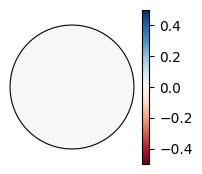

In [7]:
plotting.plot_spherical_fn(pred[0,0].cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)), vmin=-0.5, vmax=0.5)

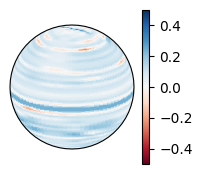

In [8]:
plotting.plot_spherical_fn(target[0,0].cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)), vmin=-0.5, vmax=0.5)

frame=0
frame=10
frame=20
frame=30
frame=40
frame=50
frame=60
frame=70
frame=80


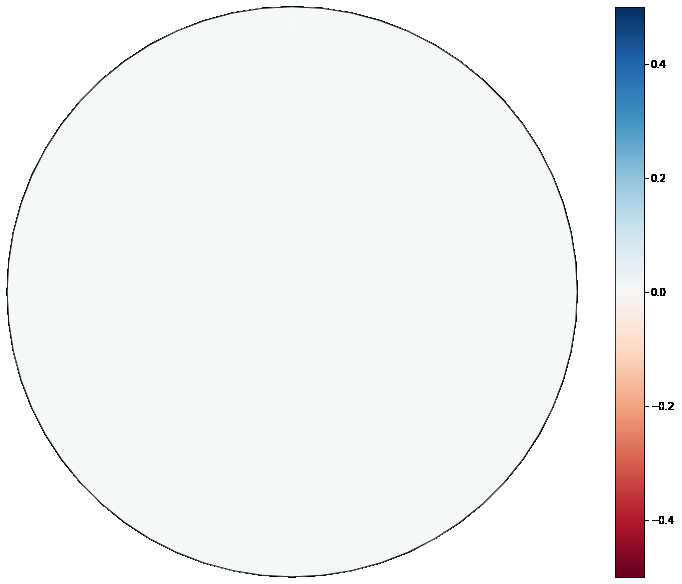

In [9]:
import matplotlib.animation as animation

fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'pred.gif', dpi=72)

num_frames = 90
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
    plotting.plot_spherical_fn(pred[0,0].cpu().squeeze().numpy(), fig=fig, central_longitude=lon, vmin=-0.5, vmax=0.5)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

TypeError: Dimensions of C (2, 244, 84) should be one smaller than X(84) and Y(244) while using shading='flat' see help(pcolormesh)

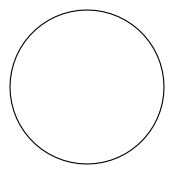

In [10]:
plotting.plot_spherical_fn(target.cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)), vmin=target.cpu().min(), vmax=target.cpu().max())

In [ ]:
import matplotlib.animation as animation

fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'target.gif', dpi=72)

num_frames = 90
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
    plotting.plot_spherical_fn(target[0,0].cpu().squeeze().numpy(), fig=fig, central_longitude=lon, vmin=-0.5, vmax=0.5)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

In [ ]:
plotting.plot_spherical_fn(np.abs(target.cpu().squeeze().numpy() - pred[0].cpu().squeeze().numpy()), fig=plt.figure(figsize=(2,2)))

fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'error.gif', dpi=72)

num_frames = 360
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
        plotting.plot_spherical_fn(np.abs(target.cpu().squeeze().numpy() - pred.cpu().squeeze().numpy()), fig=fig, central_longitude=lon)

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()

## Ground Truth
![SegmentLocal](target.gif "segment")

## Prediction
![SegmentLocal](pred.gif "segment")

## Error
![SegmentLocal](error.gif "segment")

In [ ]:
target

import matplotlib.animation as animation

fig = plt.figure(layout='constrained', figsize=(12, 8), dpi=72)

moviewriter = animation.writers['pillow'](fps=30)
moviewriter.setup(fig, 'target.gif', dpi=72)

num_frames = 90
for frame in range(num_frames):
    # compute the rotation of the sphere
    lon = -num_frames - (360 / num_frames) * frame

    if frame % 10 == 0:
        print(f"frame={frame}")
    
    plotting.plot_spherical_fn(target.permute(1,0).cpu().squeeze().numpy(), fig=fig, central_longitude=lon, vmin=target.cpu().min(), vmax=target.cpu().max())

    plt.draw()
    moviewriter.grab_frame()

moviewriter.finish()